In [18]:
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def readPayments(file_name, date_header="PaymentDate"):
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc)
    paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA


def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

def findInterestRate(paymentDate):
    try:
        year = paymentDate.year
        sdate = historicInterest[str(year)]["start"]
        edate = historicInterest[str(year)]["end"]
        delta = edate - sdate
    
        allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)]

        if paymentDate in allDates:
            rate = historicInterest[str(year)]["rate"]
        else:
            rate = historicInterest[str(year-1)]["rate"]
    except KeyError:
        rate = historicInterest[str(year-1)]["rate"]
    return rate


def populateInterestRate(myPayments):
    myPayments["interestRate"] = 0
    myPayments["totalPayment"] = 0
    myPayments["cumulativeTotal"] = 0
    for i, row in myPayments.iterrows():
    #     print(row)
        rate = findInterestRate(myPayments.at[i, "PaymentDate"].date())
#         print(rate)
        myPayments.loc[i,"interestRate"] = rate
#         print(rate+1)
        myPayments.loc[i, "totalPayment"] = myPayments.loc[i, "Gross"]*(rate+1)
        myPayments.loc[i, "cumulativeTotal"] = myPayments.loc[i, "Gross"]*(rate+1)
    return myPayments

def graduateAmount(simEnd, employmentStart, myPayments=None):
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = min(myPayments.PaymentDate)
        if simEnd == "yearEnd":
            graduationYear = max(myPayments.PaymentDate).year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = max(myPayments.PaymentDate) # simulation ends at final payment
            
        paymentDates = list(myPayments.PaymentDate)
        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            interestRate = findInterestRate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in paymentDates:
#                 interestRate = myPayments.loc[myPayments.PaymentDate == startDate, "interestRate"].values[0]
                cumulativeTotal += myPayments.loc[myPayments.PaymentDate == startDate, "Gross"].values[0]
            print(startDate, interestRate)
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = findInterestRate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start):
    lifetime_tax = 0
    lifetime_SF = 0
    lifetime_NIC = 0
    lifetime_earning = 0
    
    sdate = pd.Timestamp(employment_start)
    start = sdate
    edate = sdate + timedelta(days=N*365)
    delta = timedelta(days=1)

    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while sdate <= edate:
#         print(i)
        if ((sdate - start).days/365)%2==0 and ((sdate - start).days/365) > 0:
            grossSalaryPA = salaryIncrease(grossSalaryPA, mean=5000, sd=3000)
            print("Year ", ((sdate - start).days/365), " salary increase to ", grossSalaryPA)
        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if sdate == offset.rollforward(sdate) and sdate.month == offset.rollforward(sdate).month:
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            print("INSTALMENT paid ", calcStudentFinPM(grossSalaryPA), "Cumulative total: ", cumulativeTotal)
#         print(sdate, " Today's Amount: ", cumulativeTotal)
        sdate += delta
    
    return cumulativeList


#         print("salary: ", grossSalaryPA, ". Student finance cumulative: ", lifetime_SF)
#         if i == 30:
#             print("***************30 YEARS***************")
        
#     print("Across {} years of earning \nat a final gross salary of {} per year \nYou paid a total of: \n{} in tax \n{} in NIC \n{} in Student Finance".format(N, grossSalaryPA, lifetime_tax, lifetime_NIC, lifetime_SF))
#     print("Across {} years of earning \nat you earned a cumulative gross salary of {}".format(N, lifetime_earning))

In [20]:
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)

In [21]:
## Web scrape historic interest rates

url = 'https://www.gov.uk/guidance/how-interest-is-calculated-plan-2'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')
table_rows = results.find_all('tr')
historicInterest = {}
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) > 0:
        row[0] = row[0].split('to')
        row[0][0] = pd.Timestamp(row[0][0])
        row[0][1] = pd.Timestamp(row[0][1])
        year = str(row[0][0].year)
        historicInterest.setdefault(year, 0)
        historicInterest[year] = {}
        historicInterest[year].setdefault("start", 0)
        historicInterest[year]["start"] = row[0][0].date()
        historicInterest[year].setdefault("end", 0)
        historicInterest[year]["end"] = row[0][1].date()
        historicInterest[year].setdefault("rate", 0)
        historicInterest[year]["rate"] = float(row[1][:-1])/100

In [22]:
cumulativeList = simulateLifetimeEarnings(grossSalaryPA = 35000, 
                                          N = 30, 
                                          principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                          employment_start = "2019-10-07")

2014-09-25 00:00:00 0.055
2014-09-26 00:00:00 0.055
2014-09-27 00:00:00 0.055
2014-09-28 00:00:00 0.055
2014-09-29 00:00:00 0.055
2014-09-30 00:00:00 0.055
2014-10-01 00:00:00 0.055
2014-10-02 00:00:00 0.055
2014-10-03 00:00:00 0.055
2014-10-04 00:00:00 0.055
2014-10-05 00:00:00 0.055
2014-10-06 00:00:00 0.055
2014-10-07 00:00:00 0.055
2014-10-08 00:00:00 0.055
2014-10-09 00:00:00 0.055
2014-10-10 00:00:00 0.055
2014-10-11 00:00:00 0.055
2014-10-12 00:00:00 0.055
2014-10-13 00:00:00 0.055
2014-10-14 00:00:00 0.055
2014-10-15 00:00:00 0.055
2014-10-16 00:00:00 0.055
2014-10-17 00:00:00 0.055
2014-10-18 00:00:00 0.055
2014-10-19 00:00:00 0.055
2014-10-20 00:00:00 0.055
2014-10-21 00:00:00 0.055
2014-10-22 00:00:00 0.055
2014-10-23 00:00:00 0.055
2014-10-24 00:00:00 0.055
2014-10-25 00:00:00 0.055
2014-10-26 00:00:00 0.055
2014-10-27 00:00:00 0.055
2014-10-28 00:00:00 0.055
2014-10-29 00:00:00 0.055
2014-10-30 00:00:00 0.055
2014-10-31 00:00:00 0.055
2014-11-01 00:00:00 0.055
2014-11-02 0

2015-11-10 00:00:00 0.039
2015-11-11 00:00:00 0.039
2015-11-12 00:00:00 0.039
2015-11-13 00:00:00 0.039
2015-11-14 00:00:00 0.039
2015-11-15 00:00:00 0.039
2015-11-16 00:00:00 0.039
2015-11-17 00:00:00 0.039
2015-11-18 00:00:00 0.039
2015-11-19 00:00:00 0.039
2015-11-20 00:00:00 0.039
2015-11-21 00:00:00 0.039
2015-11-22 00:00:00 0.039
2015-11-23 00:00:00 0.039
2015-11-24 00:00:00 0.039
2015-11-25 00:00:00 0.039
2015-11-26 00:00:00 0.039
2015-11-27 00:00:00 0.039
2015-11-28 00:00:00 0.039
2015-11-29 00:00:00 0.039
2015-11-30 00:00:00 0.039
2015-12-01 00:00:00 0.039
2015-12-02 00:00:00 0.039
2015-12-03 00:00:00 0.039
2015-12-04 00:00:00 0.039
2015-12-05 00:00:00 0.039
2015-12-06 00:00:00 0.039
2015-12-07 00:00:00 0.039
2015-12-08 00:00:00 0.039
2015-12-09 00:00:00 0.039
2015-12-10 00:00:00 0.039
2015-12-11 00:00:00 0.039
2015-12-12 00:00:00 0.039
2015-12-13 00:00:00 0.039
2015-12-14 00:00:00 0.039
2015-12-15 00:00:00 0.039
2015-12-16 00:00:00 0.039
2015-12-17 00:00:00 0.039
2015-12-18 0

2016-10-19 00:00:00 0.046
2016-10-20 00:00:00 0.046
2016-10-21 00:00:00 0.046
2016-10-22 00:00:00 0.046
2016-10-23 00:00:00 0.046
2016-10-24 00:00:00 0.046
2016-10-25 00:00:00 0.046
2016-10-26 00:00:00 0.046
2016-10-27 00:00:00 0.046
2016-10-28 00:00:00 0.046
2016-10-29 00:00:00 0.046
2016-10-30 00:00:00 0.046
2016-10-31 00:00:00 0.046
2016-11-01 00:00:00 0.046
2016-11-02 00:00:00 0.046
2016-11-03 00:00:00 0.046
2016-11-04 00:00:00 0.046
2016-11-05 00:00:00 0.046
2016-11-06 00:00:00 0.046
2016-11-07 00:00:00 0.046
2016-11-08 00:00:00 0.046
2016-11-09 00:00:00 0.046
2016-11-10 00:00:00 0.046
2016-11-11 00:00:00 0.046
2016-11-12 00:00:00 0.046
2016-11-13 00:00:00 0.046
2016-11-14 00:00:00 0.046
2016-11-15 00:00:00 0.046
2016-11-16 00:00:00 0.046
2016-11-17 00:00:00 0.046
2016-11-18 00:00:00 0.046
2016-11-19 00:00:00 0.046
2016-11-20 00:00:00 0.046
2016-11-21 00:00:00 0.046
2016-11-22 00:00:00 0.046
2016-11-23 00:00:00 0.046
2016-11-24 00:00:00 0.046
2016-11-25 00:00:00 0.046
2016-11-26 0

2017-11-29 00:00:00 0.061
2017-11-30 00:00:00 0.061
2017-12-01 00:00:00 0.061
2017-12-02 00:00:00 0.061
2017-12-03 00:00:00 0.061
2017-12-04 00:00:00 0.061
2017-12-05 00:00:00 0.061
2017-12-06 00:00:00 0.061
2017-12-07 00:00:00 0.061
2017-12-08 00:00:00 0.061
2017-12-09 00:00:00 0.061
2017-12-10 00:00:00 0.061
2017-12-11 00:00:00 0.061
2017-12-12 00:00:00 0.061
2017-12-13 00:00:00 0.061
2017-12-14 00:00:00 0.061
2017-12-15 00:00:00 0.061
2017-12-16 00:00:00 0.061
2017-12-17 00:00:00 0.061
2017-12-18 00:00:00 0.061
2017-12-19 00:00:00 0.061
2017-12-20 00:00:00 0.061
2017-12-21 00:00:00 0.061
2017-12-22 00:00:00 0.061
2017-12-23 00:00:00 0.061
2017-12-24 00:00:00 0.061
2017-12-25 00:00:00 0.061
2017-12-26 00:00:00 0.061
2017-12-27 00:00:00 0.061
2017-12-28 00:00:00 0.061
2017-12-29 00:00:00 0.061
2017-12-30 00:00:00 0.061
2017-12-31 00:00:00 0.061
2018-01-01 00:00:00 0.061
2018-01-02 00:00:00 0.061
2018-01-03 00:00:00 0.061
2018-01-04 00:00:00 0.061
2018-01-05 00:00:00 0.061
2018-01-06 0

2019-04-13 00:00:00 0.063
2019-04-14 00:00:00 0.063
2019-04-15 00:00:00 0.063
2019-04-16 00:00:00 0.063
2019-04-17 00:00:00 0.063
2019-04-18 00:00:00 0.063
2019-04-19 00:00:00 0.063
2019-04-20 00:00:00 0.063
2019-04-21 00:00:00 0.063
2019-04-22 00:00:00 0.063
2019-04-23 00:00:00 0.063
2019-04-24 00:00:00 0.063
2019-04-25 00:00:00 0.063
2019-04-26 00:00:00 0.063
2019-04-27 00:00:00 0.063
2019-04-28 00:00:00 0.063
2019-04-29 00:00:00 0.063
2019-04-30 00:00:00 0.063
2019-05-01 00:00:00 0.063
2019-05-02 00:00:00 0.063
2019-05-03 00:00:00 0.063
2019-05-04 00:00:00 0.063
2019-05-05 00:00:00 0.063
2019-05-06 00:00:00 0.063
2019-05-07 00:00:00 0.063
2019-05-08 00:00:00 0.063
2019-05-09 00:00:00 0.063
2019-05-10 00:00:00 0.063
2019-05-11 00:00:00 0.063
2019-05-12 00:00:00 0.063
2019-05-13 00:00:00 0.063
2019-05-14 00:00:00 0.063
2019-05-15 00:00:00 0.063
2019-05-16 00:00:00 0.063
2019-05-17 00:00:00 0.063
2019-05-18 00:00:00 0.063
2019-05-19 00:00:00 0.063
2019-05-20 00:00:00 0.063
2019-05-21 0

Year  8.0  salary increase to  53758.896069335075
INSTALMENT paid  210.32172052001306 Cumulative total:  56229.077354339344
INSTALMENT paid  210.32172052001306 Cumulative total:  56265.76333386198
INSTALMENT paid  210.32172052001306 Cumulative total:  56294.87003333601
INSTALMENT paid  210.32172052001306 Cumulative total:  56324.10059091936
INSTALMENT paid  210.32172052001306 Cumulative total:  56337.961792110145
INSTALMENT paid  210.32172052001306 Cumulative total:  56367.37571860397
INSTALMENT paid  210.32172052001306 Cumulative total:  56373.65793470242
INSTALMENT paid  210.32172052001306 Cumulative total:  56418.735382219464
INSTALMENT paid  210.32172052001306 Cumulative total:  56440.73260719993
INSTALMENT paid  210.32172052001306 Cumulative total:  56470.58385565331
INSTALMENT paid  210.32172052001306 Cumulative total:  56500.56213050478
INSTALMENT paid  210.32172052001306 Cumulative total:  56515.12568935594
INSTALMENT paid  210.32172052001306 Cumulative total:  56553.0682454517

INSTALMENT paid  566.4947757517497 Cumulative total:  29575.25811915049
INSTALMENT paid  566.4947757517497 Cumulative total:  29138.683961518484
INSTALMENT paid  566.4947757517497 Cumulative total:  28696.18339908994
INSTALMENT paid  566.4947757517497 Cumulative total:  28239.95996754975
INSTALMENT paid  566.4947757517497 Cumulative total:  27801.405484220853
INSTALMENT paid  566.4947757517497 Cumulative total:  27349.39028979557
INSTALMENT paid  566.4947757517497 Cumulative total:  26887.991511956832
INSTALMENT paid  566.4947757517497 Cumulative total:  26439.61250930023
INSTALMENT paid  566.4947757517497 Cumulative total:  25981.989775007558
INSTALMENT paid  566.4947757517497 Cumulative total:  25518.90931601384
INSTALMENT paid  566.4947757517497 Cumulative total:  25064.516096864612
INSTALMENT paid  566.4947757517497 Cumulative total:  24604.67867598387
INSTALMENT paid  566.4947757517497 Cumulative total:  24142.884503064008
INSTALMENT paid  566.4947757517497 Cumulative total:  2367

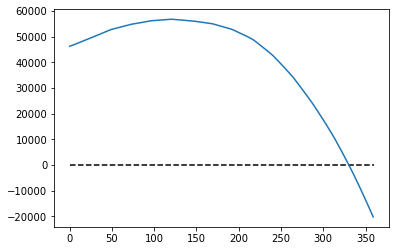

In [27]:
plt.plot(cumulativeList)
plt.hlines(y=0, xmin=0, xmax=len(cumulativeList), linestyle = '--')
plt.show()

In [7]:
myPayments = populateInterestRate(myPayments)
myPayments.head()

,PaymentDate,Instalment,Gross,interestRate,totalPayment,cumulativeTotal
0,2014-09-25,1,1191.3,0.055,1256.8215,1256.8215
1,2014-10-15,1,2250.0,0.055,2373.7500,2373.7500
2,2015-01-05,2,1191.3,0.055,1256.8215,1256.8215
3,2015-02-04,2,2250.0,0.055,2373.7500,2373.7500
4,2015-04-20,3,1227.4,0.055,1294.9070,1294.9070
